In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model
import numpy as np
import os
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full

import tensorflow.keras.layers as KL
import voxelmorph as vxm
from utils import *
import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import glob
import pathlib

en=[16,16, 32,32, 64,64,128,128, 256,256]
de=[256,256, 128,128,64,64,32,32,16,16,2]
nb_features = '_'.join(map(str, en))

nb_conv_per_level=2
batch_size=1
initial_epoch=800
dimx=192
dimy=192
dimz=192
num_labels = 8
num_shapes = 1

log_dir='logs_synth_mom_brain_params_'+str(nb_features)+'_nc_'+str(nb_conv_per_level)+'_bs_'+str(batch_size)
models_dir='models_synth_mom_brain_params_'+str(nb_features)+'_nc_'+str(nb_conv_per_level)+'_bs_'+str(batch_size)
data_dir = '/autofs/cluster/scratch/friday/for_javid/'
checkpoint_path=models_dir+'/weights_epoch_'+str(initial_epoch)+'.h5'

feta = pathlib.Path('/autofs/space/bal_004/users/jd1677/synthstrip/feta_2.1')
files = list(feta.glob('sub-???/anat/sub-???_rec-mial_dseg.nii.gz'))
label_maps = [np.uint8(f.dataobj) for f in map(nib.load, files)]
label_maps = crop_img(label_maps,dimx,dimy,dimz)
label_maps = label_maps[0:num_shapes]
labels = np.unique(label_maps)
in_shape = label_maps[0].shape

nb_labels=8



batch_size=1
warp_max=2   
warp_max=2.5
warp_min=.5
warp_blur_min=np.array([2, 4, 8])
warp_blur_max=warp_blur_min*2
bias_blur_min=np.array([2, 4, 8])
bias_blur_max=bias_blur_min*2
initial_lr=1e-4
nb_conv_per_level=2

nb_levels=5
conv_size=3
num_epochs=50000
num_bg_labels=16
warp_fwhm_min=10
warp_fwhm_max=20
warp_min_shapes=10
warp_max_shapes=50
in_shape=(dimx,dimy,dimz)
bg_brain = True

warp_max=2
warp_min=1
image_fwhm_min=20
image_fwhm_max=40
aff_shift=30
aff_rotate=180
aff_shear=0.1
blur_max=3.4
slice_prob=1
crop_prob=1
bias_min=0.01
bias_max=0.2
zero_background=0.1
up_scale=False
aff_scale=0.8


labels_in = range(max(labels) + num_labels + 1)

gen_arg = {
    'in_shape': in_shape,
    'labels_in': labels_in,
    'labels_out': {f: 2 if f in (1, 2, 3, 4, 5, 6, 7) else 1 for f in labels_in},
    'one_hot':True,
    'aff_shift':aff_shift,
    'aff_rotate':aff_rotate,
    'aff_shear':aff_shear,
    'aff_scale':aff_scale,
    'up_scale':False,
    'zero_background':zero_background
}

def plot_first_slices(array):
    num_images = len(array)
    num_cols = 3  # Number of columns in the plot grid
    num_rows = (num_images + num_cols - 1) // num_cols  # Number of rows in the plot grid

    plt.figure(figsize=(15, 5 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(array[i][:, :, 0], cmap='tab20c')  # Plot the first slice of each 3D image
        plt.title(f'Image {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    





# ne.plot.volume3D(data_0)


############################# TRAINING #############################################################
# en=[16,32,64,64,64,64,64]
# de=[64,64,64,64,64,32,16,2]
# num_shapes = 5
# num_rows = 1
# num_cols = 5

# # if args.:
# nb_features = '_'.join(map(str, en))
    

# log_dir='logs_feta'
# models_dir='models_feta_mom_brain_params_'+str(nb_features)
# initial_epoch=1000
# checkpoint_path=models_dir+'/weights_epoch_'+str(initial_epoch)+'.h5'

print("here dddd ")
labels_to_image_model = ne.models.labels_to_image_new(**gen_arg)#,input_model=labels_to_labels_model)

unet_model = vxm.networks.Unet(inshape=(dimx, dimy,dimz, 1), nb_features=[en, de], 
                               nb_conv_per_level=nb_conv_per_level,
                               final_activation_function='softmax')
input_img = Input(shape=(dimx, dimy,dimz,1))
generated_img, y = labels_to_image_model(input_img)

segmentation = unet_model(generated_img)
combined_model = Model(inputs=input_img, outputs=segmentation)
combined_model.add_loss(soft_dice(y, segmentation))

combined_model.compile(optimizer=Adam(learning_rate=initial_lr))
shapes = [draw_shapes(in_shape, num_labels) for _ in range(num_shapes)]
shapes = map(np.squeeze, shapes)
shapes = map(np.uint8, shapes)
shapes = [f + max(labels) + 1 for f in shapes]
gen = generator(label_maps, shapes)

if os.path.exists(checkpoint_path):
    combined_model.load_weights(checkpoint_path)
    print("Loaded weights from the checkpoint and continued training.")
else:
    print("Checkpoint file not found.")


print("here gggg ")


combined_images=[]
y_preds=[]
y_masks=[]

num_iterations = 10  # Set the number of iterations as needed


2023-11-28 14:43:24.552947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/autofs/cluster/scratch/friday/javid/tensorflow_2.13.0-gpu-user-base/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Issue loading cv2


here dddd 


2023-11-28 14:43:41.778048: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-28 14:43:41.778110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: tebo.nmr.mgh.harvard.edu
2023-11-28 14:43:41.778125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: tebo.nmr.mgh.harvard.edu
2023-11-28 14:43:41.778539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-11-28 14:43:41.778594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.54.3


only down scaling
(None, 192, 192, 192, 1)
(None, 192, 192, 192, 1)
only down scaling
Loaded weights from the checkpoint and continued training.
here gggg 


only down scaling
1/1 [==============================] - 29s 29s/step


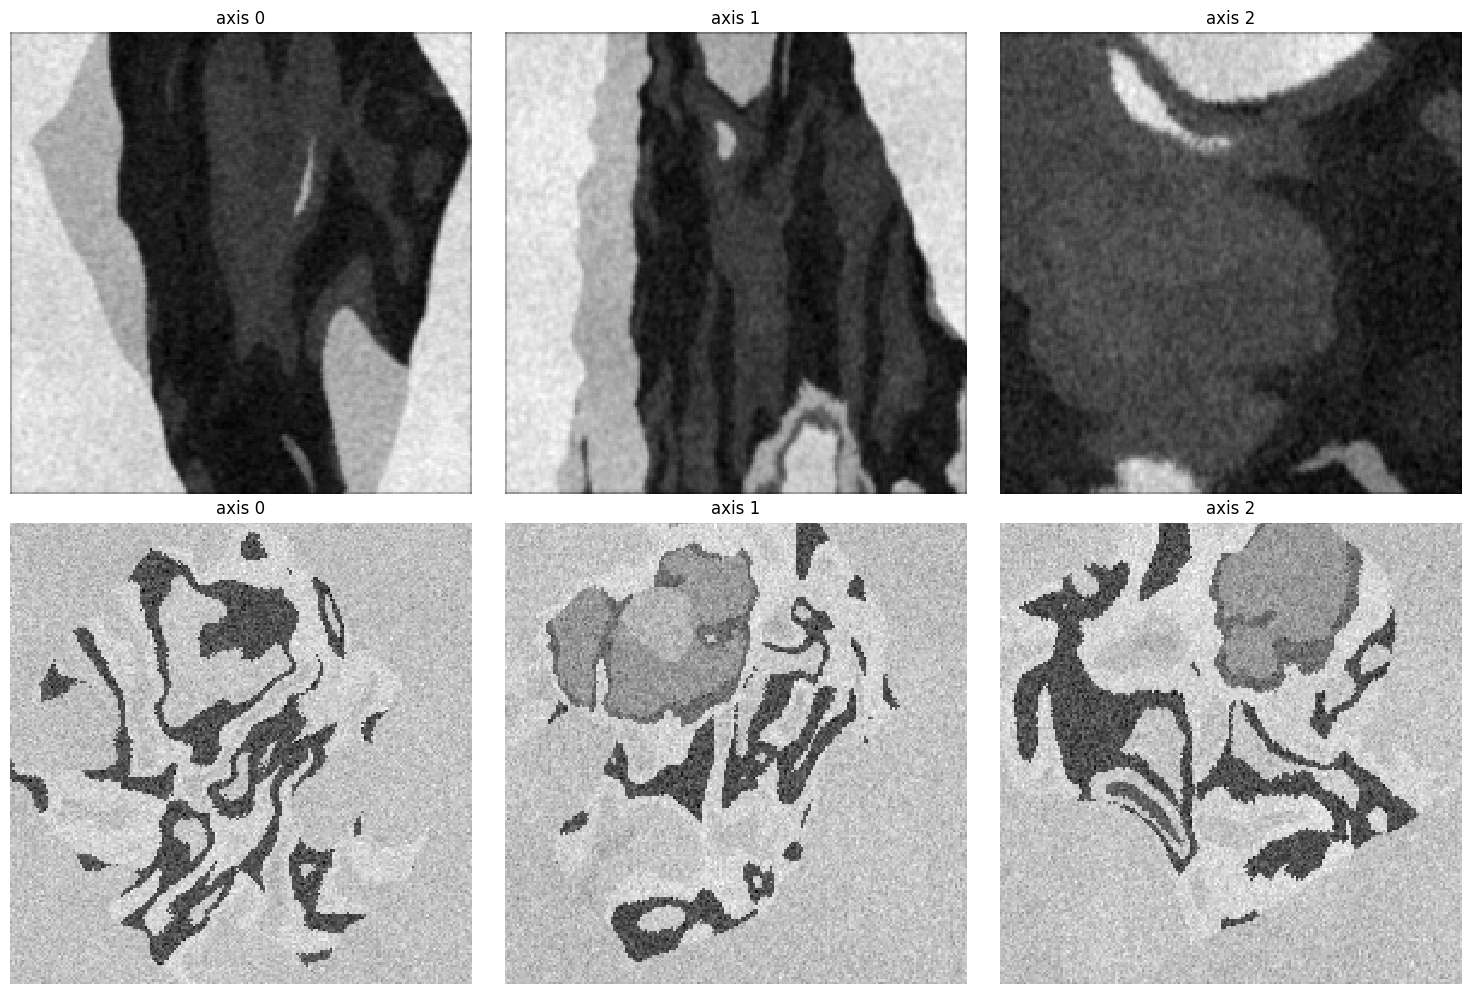

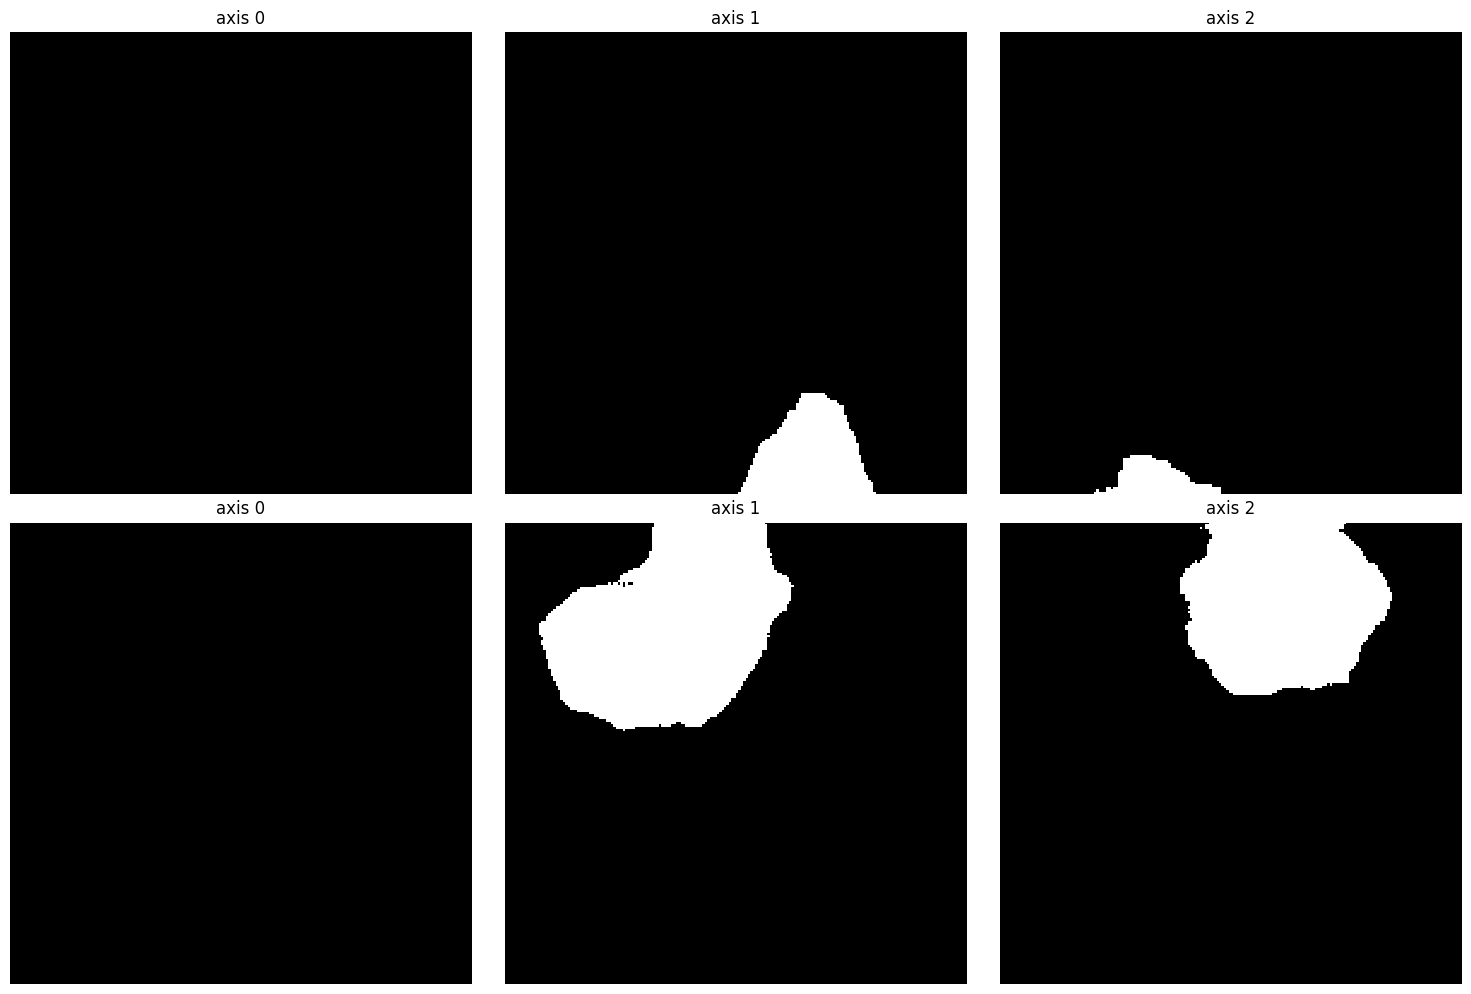

In [2]:
num_row = 1
per_row = 2
def process_label_map(label_map, labels_to_image_model, unet_model):
    lm = np.expand_dims(label_map, axis=-1)
    im, _ = labels_to_image_model.predict(lm)
    predictions = unet_model.predict(im, verbose=0)
    predictions_argmax = np.argmax(predictions, axis=-1)
    return im, predictions_argmax
    
for i in range(0, num_row * per_row, per_row):
    slices = [next(gen) for _ in range(per_row)]
    images, predictions = zip(*[process_label_map(lm, labels_to_image_model, unet_model) for lm in slices])

    # ne.plot.volume3D(slices, cmaps=['tab20c'])
    ne.plot.volume3D(images, cmaps=['gray'])
    ne.plot.volume3D(predictions, cmaps=['gray'])